# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**


    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
**Целевой признак**

    Price — цена (евро)

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q
!pip install lightgbm -q
!pip install missingno -q
!pip install wordcloud==1.8.2.2 -q

import time
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import wordcloud
import warnings

%matplotlib inline
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="interval columns not set")

from phik import phik_matrix

from wordcloud import WordCloud

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

## Подготовка данных

### Загрузка данных и первичный анализ

In [2]:
auto_data_raw = pd.read_csv('/datasets/autos.csv')
auto_data_raw.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Названия столбцов некорректны

In [3]:
auto_data_raw = auto_data_raw.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox_type',      
    'Power': 'engine_power',         
    'Kilometer': 'mileage',          
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Repaired': 'repair_status',   
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen',
    'Model': 'model',
    'Brand': 'brand'
})

In [4]:
auto_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox_type        334536 non-null  object
 5   engine_power        354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repair_status       283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

В некоторых параметрах присутствуют пропуски, кроме того временные столбцы имеют неправильный тип данных

In [5]:
time_cols = ['date_crawled', 'date_created', 'last_seen']
for col in time_cols:
    auto_data_raw[col] = pd.to_datetime(auto_data_raw[col])

#### Преобразование временных признаков

Посмотрим, какие уникальные значения встерчаются во временных столбцах

In [6]:
for col in time_cols:
    print(col)
    print('Года:', auto_data_raw[col].dt.year.unique())
    print('Месяцы:', auto_data_raw[col].dt.month.unique(), end='\n\n')

date_crawled
Года: [2016]
Месяцы: [3 4]

date_created
Года: [2016 2015 2014]
Месяцы: [ 3  4  2  1 11 12  9  8  6]

last_seen
Года: [2016]
Месяцы: [4 3]



Таким образом, временные столбцы имеют слишком маленький период, так что можно их преобразовать в числовые признаки

При этом, количество объявлений, сделанных в 2015 году(столбец date_created) слишком мало, чтобы выделять под год создания целый столбец

In [7]:
auto_data_raw[auto_data_raw['date_created'].dt.year == 2015].shape[0]

25

In [8]:
auto_data_raw['crawled_month'] = auto_data_raw['date_crawled'].dt.month
auto_data_raw['last_seen_month'] = auto_data_raw['last_seen'].dt.month

auto_data_raw['created_month'] = auto_data_raw['date_created'].dt.month

auto_data_raw.drop(['date_crawled', 'last_seen', 'date_created'], axis=1, inplace=True)

#### Поиск аномальных значений

Проверим данные на наличие аномальных значений

In [9]:
# эта функция рисует графики распределения значений количественных признаков
# с указанием названия графика и признака
def num_vals_distribution(data, xcols, titles, xlabels, figsize, minus):
    fig, axs = plt.subplots(len(xcols), 2, figsize=figsize)
    for i in range(len(xcols)):
        sns.histplot(data=auto_data_raw, x=xcols[i], bins=20, ax=axs[i, 0])
        axs[i,0].set_xlabel(xlabels[i])
        axs[i,0].set_ylabel('Количество')
        axs[i,0].set_title(titles[i])

        sns.boxplot(data=auto_data_raw[xcols[i]], orient='h', ax=axs[i, 1])
        axs[i,1].set_xlabel(xlabels[i])
        axs[i,1].set_title(titles[i])
    
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show();

In [10]:
auto_data_raw.head()

,price,vehicle_type,registration_year,gearbox_type,engine_power,model,mileage,registration_month,fuel_type,brand,repair_status,number_of_pictures,postal_code,crawled_month,last_seen_month,created_month
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,3,4,3
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954,3,4,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480,3,4,3
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074,3,3,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437,3,4,3


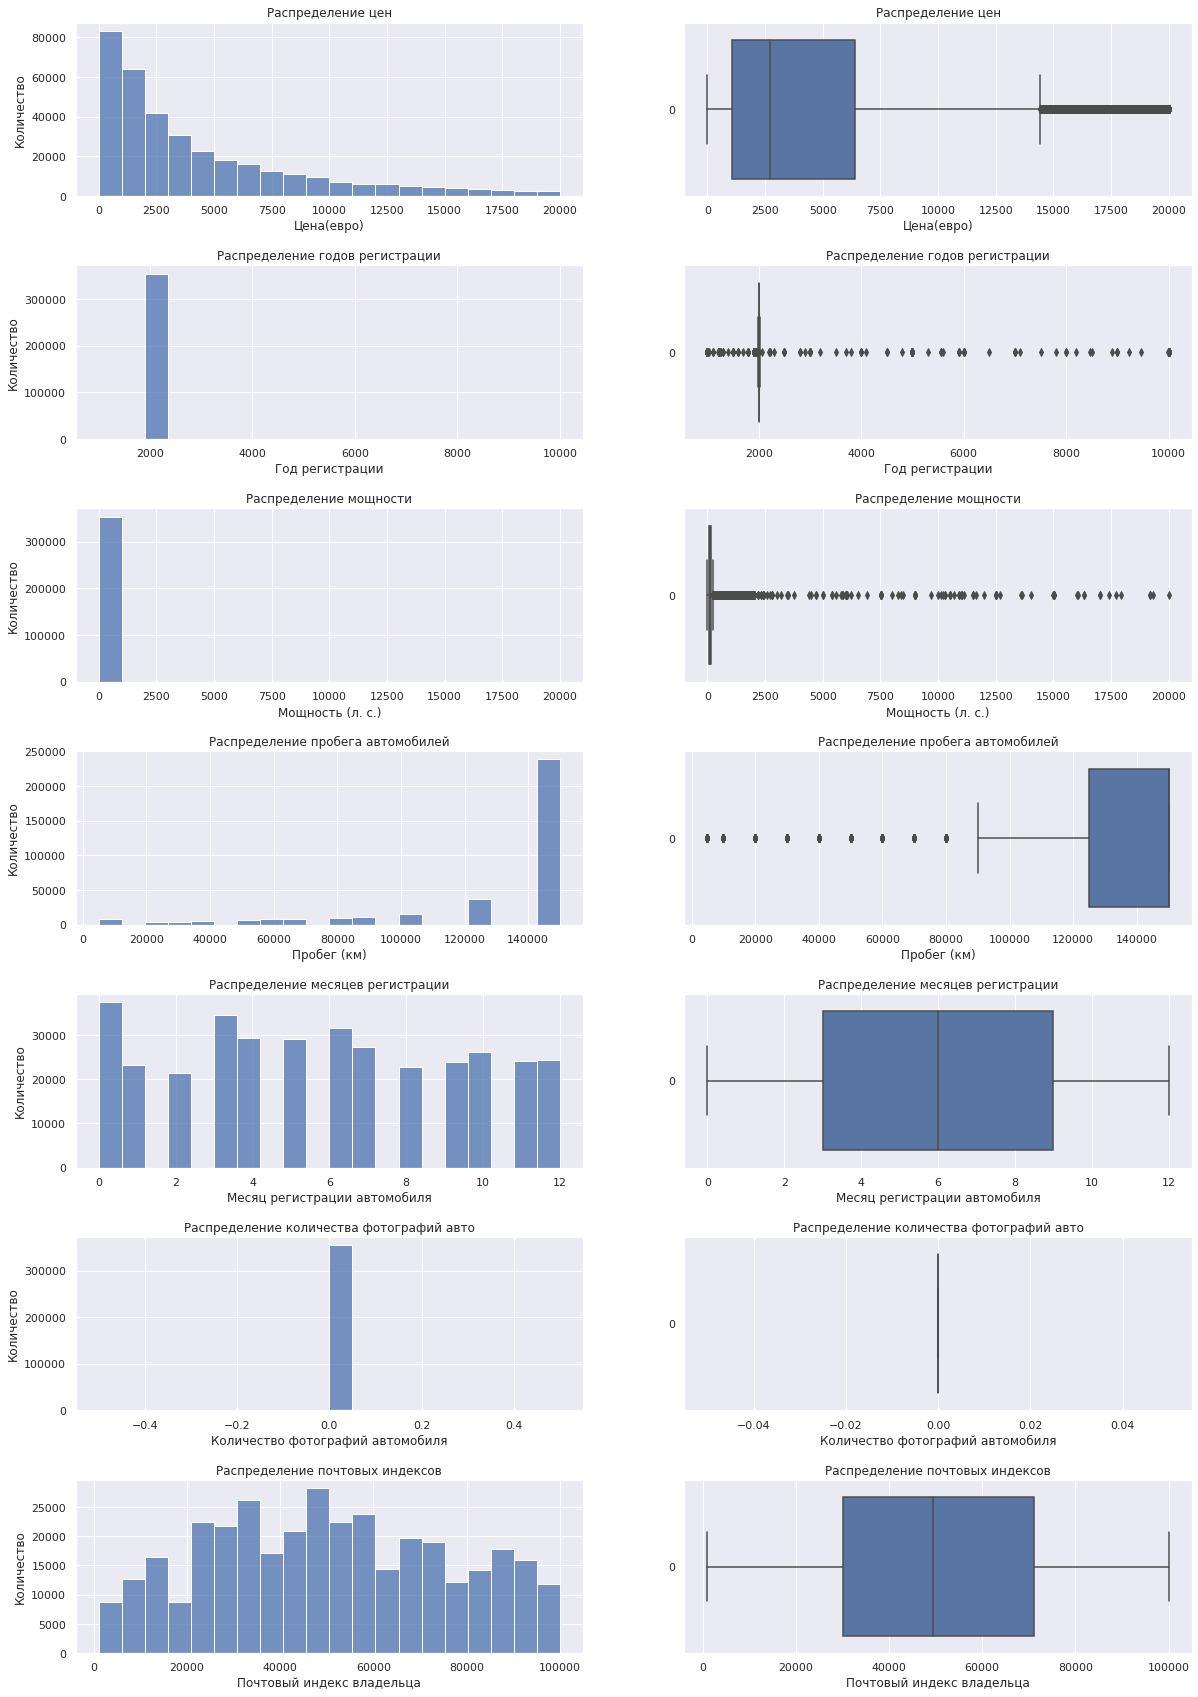

In [11]:
num_cols = ['price', 'registration_year', 
       'engine_power', 'mileage', 'registration_month',
       'number_of_pictures', 'postal_code']

auto_data_num_xlabel = [
    'Цена(евро)',
    'Год регистрации',
    'Мощность (л. с.)',
    'Пробег (км)',
    'Месяц регистрации автомобиля',
    'Количество фотографий автомобиля',
    'Почтовый индекс владельца'
]

auto_data_num_title = [
    'Распределение цен',
    'Распределение годов регистрации',
    'Распределение мощности',
    'Распределение пробега автомобилей',
    'Распределение месяцев регистрации',
    'Распределение количества фотографий авто',
    'Распределение почтовых индексов'
]
num_vals_distribution(auto_data_raw,
                      num_cols, 
                      auto_data_num_title,
                      auto_data_num_xlabel,
                      (20, 30),
                      1
                     )

**Какие выводы можно сделать по этим графикам:**

- В целевом признаке *price* присутствуют значения меньше 200 евро - аномальные значения, которые тяжело исправить. Я предпочту от них избавиться, так как изменение таргета может плохо сказаться на модели предсказания.


- В столбце *registration_year* присутствует большое количество некорректных значений(год регистрации превышает время выгрузки) или автомобилей, которые могут внести "шум" в модель (с годом регистрации меньше 1980). Следует узнать у заказчика дату последней выгрузки данных, а также возможность размещения коллекционных автомобилей на сервисе. Такие значения следует удалить, так как нет возможности изменить указанный год на верный.


- Столбец *engine_power* также содержит аномальные значения(вряд ли на б.у. рынке есть машины с мощностью двигателя больше 1000 и меньше 40). В этом случае завышенные значения могут быть ошибками пользователя, так что их можно исправить на меньшие. 


- Столбец *number_of_pictures* содержит только нулевые значения, а значит этот признак является неинформативным и его следует удалить.

In [12]:
auto_data_raw = auto_data_raw[auto_data_raw['price'] > 200]

In [13]:
auto_data_raw = auto_data_raw[
    (auto_data_raw['registration_year'] > 1980) & 
    (auto_data_raw['registration_year'] < 2016)
]

In [14]:
def divide_power_by_10(i):
    return i/10 if i > 1000 else i

auto_data_raw = auto_data_raw[
    (auto_data_raw['engine_power'] > 30) & 
    (auto_data_raw['engine_power'] < 10000)
]
auto_data_raw['engine_power'] = auto_data_raw['engine_power'].apply(divide_power_by_10)

In [15]:
auto_data_raw.drop('number_of_pictures', axis=1, inplace=True)
auto_data_raw.reset_index(drop=True, inplace=True)

Посмотрим на распределение брендом автомомбилей с помощью облака слов

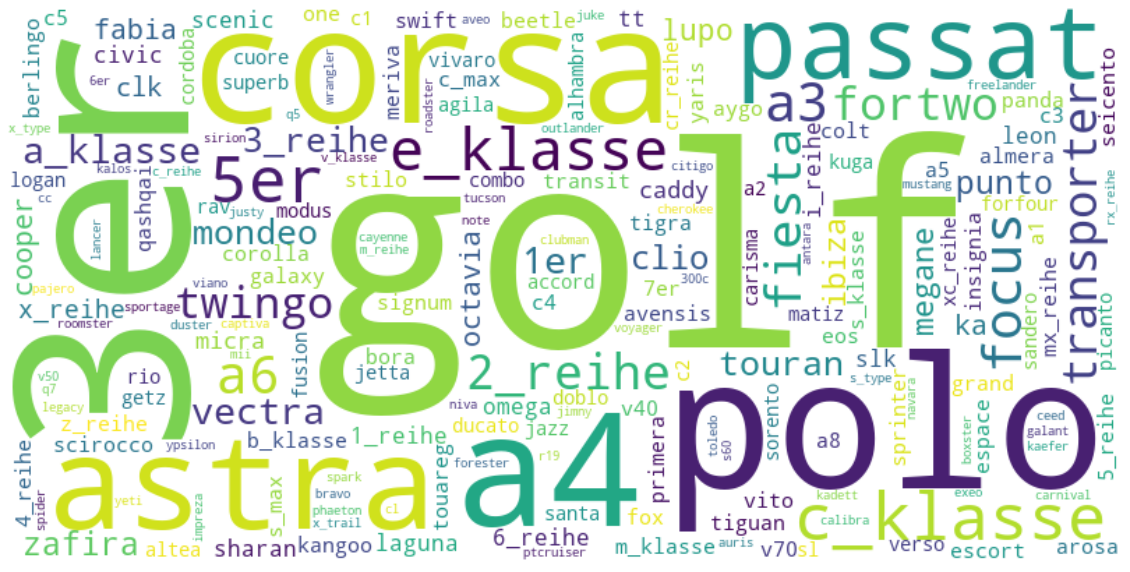

In [16]:
all_models = " ".join(auto_data_raw['model'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_models)

plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Обработка пропущенных значений

Посмотрим, сколько пропусков оказалось в датасете

In [17]:
pd.DataFrame(round(auto_data_raw.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
repair_status,13.500000
fuel_type,4.200000
model,3.300000
gearbox_type,1.600000
vehicle_type,1.500000
price,0.000000
registration_year,0.000000
engine_power,0.000000
mileage,0.000000
registration_month,0.000000


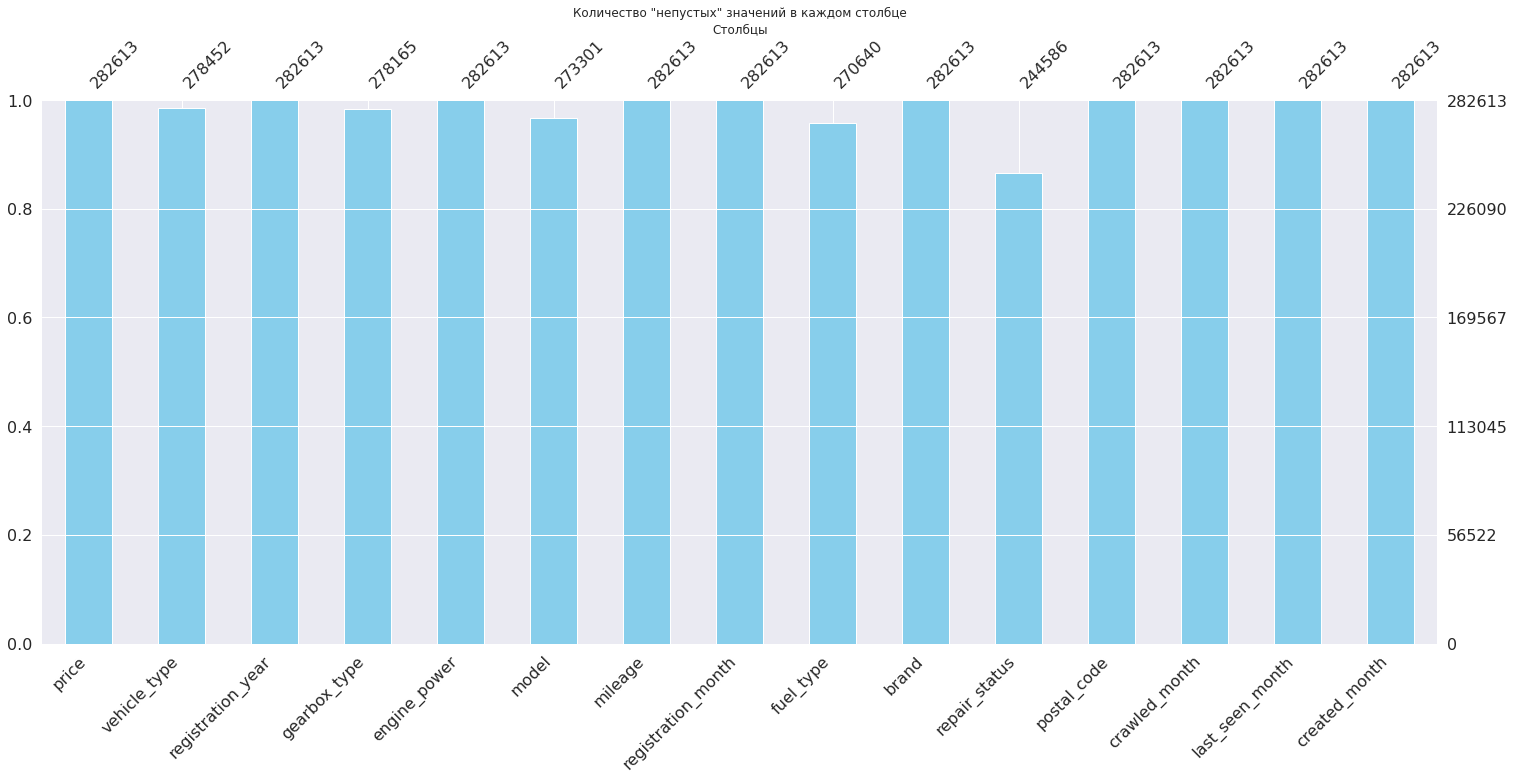

In [18]:
msno.bar(auto_data_raw, color="skyblue")
plt.title('Количество "непустых" значений в каждом столбце')
plt.xlabel('Столбцы')
plt.show();

Посмотрим, связаны ли пропуски в одном столбце с пропусками в других параметрах

<AxesSubplot:>

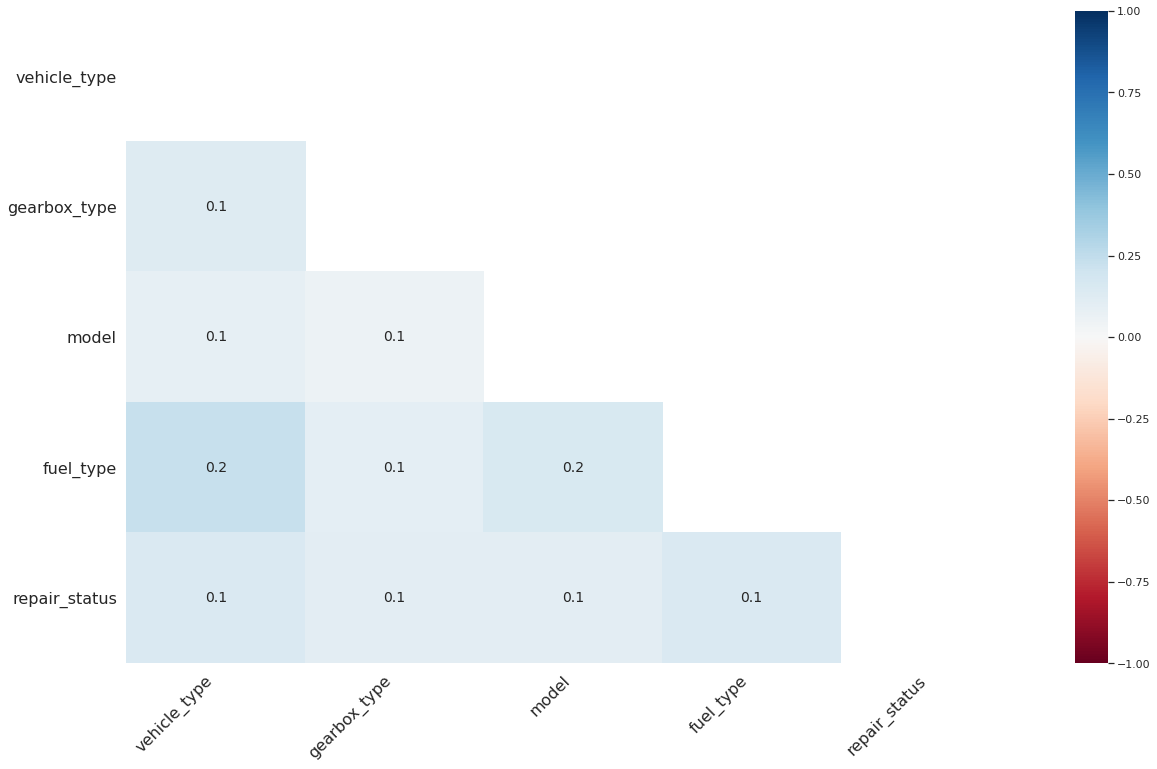

In [19]:
msno.heatmap(auto_data_raw)

Интересно, что пропуски находятся только в категориальных столбцах. Так, признак *repair_status* содержит целых 13.5% пропущенных значений. Из-за того, что столбец категориальный, будет трудно правильно импутировать значение, а значит, следует выбирать между удалением столбца, удалением строк с пропусками и заменой пропусков на какое-то одно значение.

В результате [корреляционного анализа](#corr) мы поймём, что данный параметр довольно важен в процессе ценообразования, так что удаление не подходит

Удаление строк приведёт к потере целых 52 000 значений, что может плохо сказаться на точности модели

Так что я выберу замену пропусков в столбце *repair_status* на новую категорию 'unknown'

В то же время остальные столбцы содержат слишком малое количество пропусков для создания новой категории, так что просто удалим строки с пропусками

In [20]:
auto_data_raw['repair_status'].fillna('unknown', inplace=True)
auto_data_raw.dropna(inplace=True)

#### Обработка дубликатов

Проверим данные на наличие явных и неявных дубликатов

In [21]:
auto_data_raw.duplicated().sum()

14711

Довольно большок количество повторяющихся значений. Следует узнать у сервиса, не произошло ли каких-либо ошибок в процессе сбора и выгрузки данных

In [22]:
auto_data_raw.drop_duplicates(inplace=True)

Теперь посмотрим, встречаются ли неявные дубликаты в категориальных признаках

In [23]:
for col in auto_data_raw.select_dtypes(include='object'):
    print(f' {col}: {auto_data_raw[col].unique()}\n')

 vehicle_type: ['suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']

 gearbox_type: ['auto' 'manual']

 model: ['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'one' 'fortwo' 'clio' '1er' 'b_klasse'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a1' 'focus' 'a4' 'tt' 'astra' 'a6' 'jazz'
 'polo' 'slk' '7er' 'combo' 'corsa' '80' '147' 'z_reihe' 'sorento' 'ibiza'
 'mustang' 'eos' 'touran' 'getz' 'insignia' 'ka' 'megane' 'a3' 'lupo'
 'r19' 'mondeo' 'colt' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda'
 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan' 'caddy'
 'omega' 'cuore' 's_max' 'modus' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'sharan' 'avensis' 'roomster' 'sl' 'santa' 'leon' 'cooper' 'a5'


'gasoline' и 'petrol', 'rangerover' и 'range_rover' - это одно и то же, так что нужно объединить

Кроме того, можно объединить некоторые модели автомобилей: 'golf', 'golf_3', 'golf_4'  объединить в 'golf'. Но я не вижу в этом особого смысла

In [24]:
auto_data_raw['fuel_type'] = auto_data_raw['fuel_type'].apply(lambda x: 'petrol' if x == 'gasoline' else x)
auto_data_raw['model'] = auto_data_raw['model'].apply(lambda x: 'rangerover' if x == 'range_rover' else x)

<a id="corr"></a> 
#### Корреляционный анализ

Посмотрим, как взаимосвязаны признаки в датасете

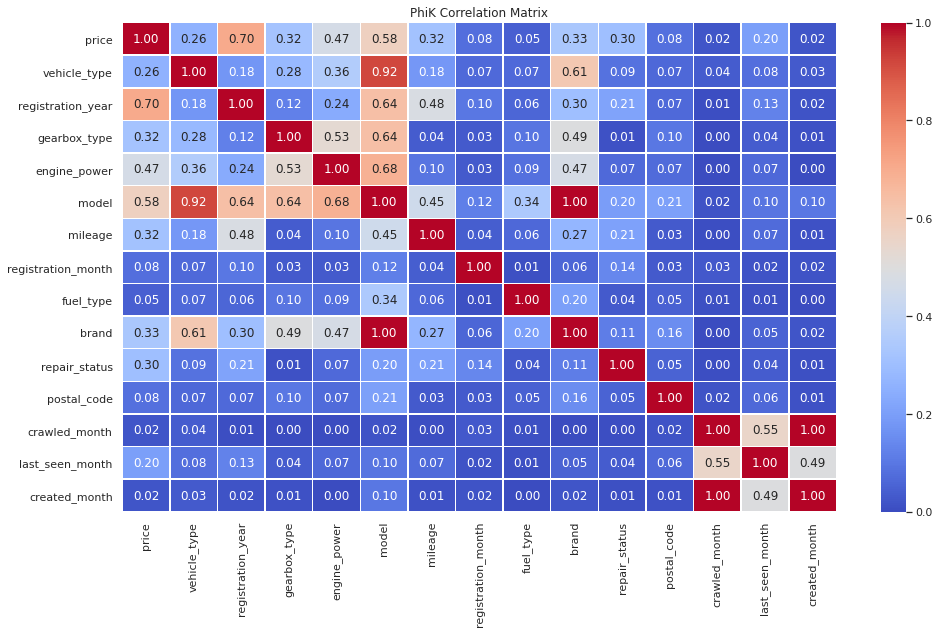

In [25]:
corr_matrix = auto_data_raw.phik_matrix(interval_cols=['price', 'registration_year', 'engine_power', 'mileage',
                                                       'registration_month', 'postal_code'])

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

**Какие выводы можно сделать по данному графику:**

- Признаки *model* и *brand*, *model* и *vehicle_type*, *crawled_month* и *created_month* мультиколлинеарны, так что следует оставить только те из них, которые имеют бОльшую корреляцию с таргетом

- Признаки *registration_year, engine_power, model* имеют умеренную корреляцию с целевой переменной *price*,
- Признаки *vehicle_type, gearbox_type, mileage, brand, repair_status, last_seen_month* слабо коррелируют с таргетом
- Остальные признаки слишком слабо(или вообще никак) не влияют на *price*

Таким образом, нам следует избавиться от некоторых признаков из датасета:

- *brand, vehicle_type* (мультиколлинеарны с более важным признаком model)

- *registration_month, postal_code, crawled_month, created_month* (не коррелируют с таргетом)

In [26]:
auto_data = auto_data_raw.drop(
                ['brand', 'vehicle_type', 'registration_month',
                 'postal_code', 'crawled_month', 'created_month', 'fuel_type'],
                axis=1
            )

#### Сжатие датасета

Заказчик заинетерован в том, чтобы модель была быстрообучаемой, так что можем попробовать ссжать датасет, приведя его в более экономный тип, с помощью функции

In [27]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [28]:
auto_data = optimize_memory_usage(auto_data)

Размер использования памяти: до 16.72 Mb - после 10.45 Mb (37.5%)


**В результате загрузки данных и первичного анализа:**

- был загружен датасет **auto_data_raw**
- временные столбцы были преобразованы в числовые по месяцам
- были удалены аномальные значения в числовых столбцах
- обработаны пропущенные значения(так, в признаке repair_status появилось значение 'unknown' вместо пропуска, в то время как остальные редко встречающиеся пропуски были удалены из датасета)
- произведён корреляционный анализ, в результате которого были удалены неинформативные колонки
- все изменения были сохранены в **auto_data**

## Обучение моделей

### Подготовка данных

Подготовим данные для моделей

Разделим выборки на тренировочную и тестовую

In [29]:
RANDOM_STATE=42

X, y = auto_data.drop(['price'], axis=1), auto_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.1)

Для кодирования категориальных признаков мы будем использовать OneHotEncoder

In [30]:
ohe_cols = ['gearbox_type', 'repair_status', 'last_seen_month']
ord_cols = ['registration_year', 'model']
num_cols = ['engine_power', 'mileage']

Построим пайплайн для подготовки категориальных данных

In [31]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

### Построение и обучение моделей

Заказчику очень важно качества пресказаний модели + целевая переменная в реальных единицах, а значит, можно использовать RMSE как метрику для оценки качества предсказаний моделей

Для начала, посмотрим, как линейная регрессия справится с этой задачей(всё-таки у нас есть признаки, которые сильно взаимосвязаны с таргетом)

In [34]:
data_preprocessor1 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols+ord_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

lr_pipe = Pipeline([
    ('preprocessor', data_preprocessor1),
    ('lr', LinearRegression())
])

In [35]:
lr_rmse = -cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

start_l = time.time()
lr_pipe.fit(X_train, y_train)
finish_l =  time.time()

start_p = time.time()
lr_pipe.predict(X_test)
finish_p =  time.time()

lr_stat = {'Время обучения': round(finish_l-start_l, 3),
           'Время предсказания': round(finish_p-start_p, 3),
           'RMSE': round(lr_rmse, 3)}
for key, val in lr_stat.items():
    print(f'{key}: {val}')

Время обучения: 19.493
Время предсказания: 0.251
RMSE: 2060.524


Модель оказалась довольно долгой в обучении, но её ошибка предсказания довольна мала

Cоздадим функцию, которая будет отображать время обучения, время предсказания, RMSE модели и добавлять все эти параметры в словарь

In [36]:
# отображает время обучения, время предсказания, RMSE модели и добавляет все эти параметры в словарь
def find_preprocessing_time(model):
    results_df = pd.DataFrame(model.cv_results_)
    best_score_df = results_df[results_df['rank_test_score'] == 1]

    model_stat = {'Время обучения': round(best_score_df['mean_fit_time'].iloc[0], 3),
                  'Время предсказания': round(best_score_df['mean_score_time'].iloc[0], 3),
                  'RMSE': round(-model.best_score_, 3)}
    for key, val in model_stat.items():
        print(f'{key}: {val}')
    
    return model_stat

Теперь построим на модель дерева решений

In [37]:
data_preprocessor2 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

dtree_pipe = Pipeline([
    ('preprocessor', data_preprocessor2),
    ('dtree', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [38]:
dtree_params = {
    'dtree__min_samples_leaf': range(1, 3),
    'dtree__min_samples_split': range(6, 10, 2),
    'dtree__max_depth':range(16, 22, 2),
    'dtree__max_features': range(3, 8),
    'dtree__criterion': ['friedman_mse', 'poisson']
}

In [39]:
dtree_search = RandomizedSearchCV(
    dtree_pipe,
    dtree_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

dtree_search.fit(X_train, y_train)
dtree_stat = find_preprocessing_time(dtree_search)

Время обучения: 0.767
Время предсказания: 0.086
RMSE: 1838.326


Отлично! Дерево решений смогло свести ошибку к 1838 евро, оставаясь при этом быстрообучаемой моделью

Теперь посмотрим, как покажет себя модель LightGBM

In [40]:
data_preprocessor3 = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

lgbm_pipe = Pipeline([
    ('preprocessor', data_preprocessor2),
    ('lgbm', LGBMRegressor())
])

In [41]:
lgbm_params = {
    'lgbm__n_estimators': [300, 500],
    'lgbm__learning_rate': [0.1, 0.3, 0.5]
}

In [43]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_train_lgbm[ord_cols+ohe_cols] = X_train_lgbm[ord_cols+ohe_cols].astype('category')
X_test_lgbm[ord_cols+ohe_cols] = X_test_lgbm[ord_cols+ohe_cols].astype('category')

In [44]:
lgbm_search = GridSearchCV(
    lgbm_pipe,
    lgbm_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgbm_search.fit(X_train_lgbm, y_train)
lgbm_stat = find_preprocessing_time(lgbm_search)

Время обучения: 18.115
Время предсказания: 1.279
RMSE: 1557.815


LGBM модель показала себя отлично со стороны точности, однако оказалась более долгой в плане обучения

Ещё одна модель, которая использует алгоритм градиентного бустинга - СatBoostRegressor. Посмотрим, как она покажет себя на этом датасете

In [45]:
cat_features_names = ['model', 'gearbox_type', 'repair_status', 'last_seen_month']
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features_names]

data_preprocessor4 = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

cat_feature_indices_after_transform = list(range(len(num_cols), len(num_cols) + len(cat_features_names)))

catboost_pipe = Pipeline([
    ('preprocessor', data_preprocessor4),
    ('catboost', CatBoostRegressor(verbose=0))
])


for col in cat_features_names:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [46]:
catboost_params = {
    'catboost__n_estimators': [100, 150],
    'catboost__learning_rate': [0.3, 0.5]
}

In [47]:
catboost_search = GridSearchCV(
    catboost_pipe,
    catboost_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


catboost_search.fit(X_train, y_train, catboost__cat_features=cat_feature_indices_after_transform)
catboost_stat = find_preprocessing_time(catboost_search)

Время обучения: 10.488
Время предсказания: 0.08
RMSE: 1676.275


Catboost показал себя немного хуже, чем LGBM, однако его время предсказание оказалоь меньше, чем у конкурента

## Анализ моделей

Оценим все модели и выберем лучшую, основываясь на критериях заказчика

In [48]:
models = ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor']
models_info = [lr_stat, dtree_stat, lgbm_stat, catboost_stat]

pd.DataFrame(models_info, index=models)

,Время обучения,Время предсказания,RMSE
LinearRegression,19.493,0.251,2060.524
DecisionTreeRegressor,0.767,0.086,1838.326
LGBMRegressor,18.115,1.279,1557.815
CatBoostRegressor,10.488,0.080,1676.275


Как можно заметить по этой таблице, характеристики моделей сильно разнятся, так что всё зависит от того, что для заказчика важнее. Однако, если все параметры одинаково важны, то мы выбираем CatBoostRegressor для работы с заказчиком, так все характеристики этой модели хороши

Если заказчику очень важна скорость обучения и предсказания, в то время как сама точность модели не особо важна, то выбор падает DrecisionTreeRegressor

Если заказчику важна только точность модели, а временем предсказания и обучения можно немного пренебречь, то LGBMRegressor - хороший вариант

А если нужно всё и сразу, то подойдёт CatBoostRegressor

Осталось проверить качество лучшей модели на тестовых данных

In [53]:
y_pred = catboost_search.predict(X_test)
print('RMSE лучшей модели:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Параметры лучшей модели:', catboost_search.best_params_)

RMSE лучшей модели: 1665.4285734593698
Параметры лучшей модели: {'catboost__learning_rate': 0.5, 'catboost__n_estimators': 150}


Проверим модель на адекватность с помощью DummyRegressor

In [55]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
print('RMSE тривиальной модели:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE тривиальной модели: 4646.288285642385


Наша модель предсказывает в разы точнее среднего значения!

Таким образом, полученная модель в среднем ошибается на 1665 евро, обучается за 10 секунд, а делает предсказания за 0.08 секунды(на самом деле, тут всё зависит от объёма данных). Она обладает параметрами: 'learning_rate': 0.5, 'loss_function': 'RMSE', 'verbose': False, 'n_estimators': 150.

## Общий вывод

**В ходе работы:**

- Были подготовленны скаченные данные
    - произошло преобразование временных перемен
    - были удалены аномальные значения
    - была произведена обработка пропущенных значений
    - явные и неявные дубликаты были обработаны
    - произведён корреляциооный анализ в ходе которого были удалены неинформативные столбцы
    
    
- Было обучено 4 регрессионные модели, среди которых золотой серединой оказалась модель CatBoostRegressor('learning_rate': 0.5, 'loss_function': 'RMSE', 'verbose': False, 'n_estimators': 150) Её ошибка предсказания составляет 1665 евро, а время обучения и предсказания являются достаточно небольшими